In [104]:
from cil.optimisation.functions import L2NormSquared, TotalVariation, MixedL21Norm
from cil.optimisation.operators import BlockOperator, FiniteDifferenceOperator, CompositionOperator, DiagonalOperator
from cil.optimisation.algorithms import PDHG
from cil.utilities import dataexample
from cil.plugins.ccpi_regularisation.functions import FGP_dTV
import numpy as np 

from cil.utilities import dataexample
from cil.utilities.display import show2D
from cil.recon import FDK
from cil.processors import TransmissionAbsorptionConverter, Slicer

import numpy as np

from cil.plugins.tigre import ProjectionOperator
from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import LeastSquares, TotalVariation
from cil.optimisation.operators import  BlurringOperator



# set up default colour map for visualisation
cmap = "gray"

# set the backend for FBP and the ProjectionOperator
device = 'gpu'




# Simulated sphere cone beam reconstruction using directional total variation 

In this notebook we use directional TV to reconstruct a slice from a simulated sphere cone beam dataset where the forward model involves a gaussian blur and then a tomographic cone beam projection

### CIL version 23.1.0

In [105]:
import cil
print(cil.__version__)

23.1.0


## Load data 

FDK recon

Input Data:
	angle: 60
	horizontal: 128

Reconstruction Volume:
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



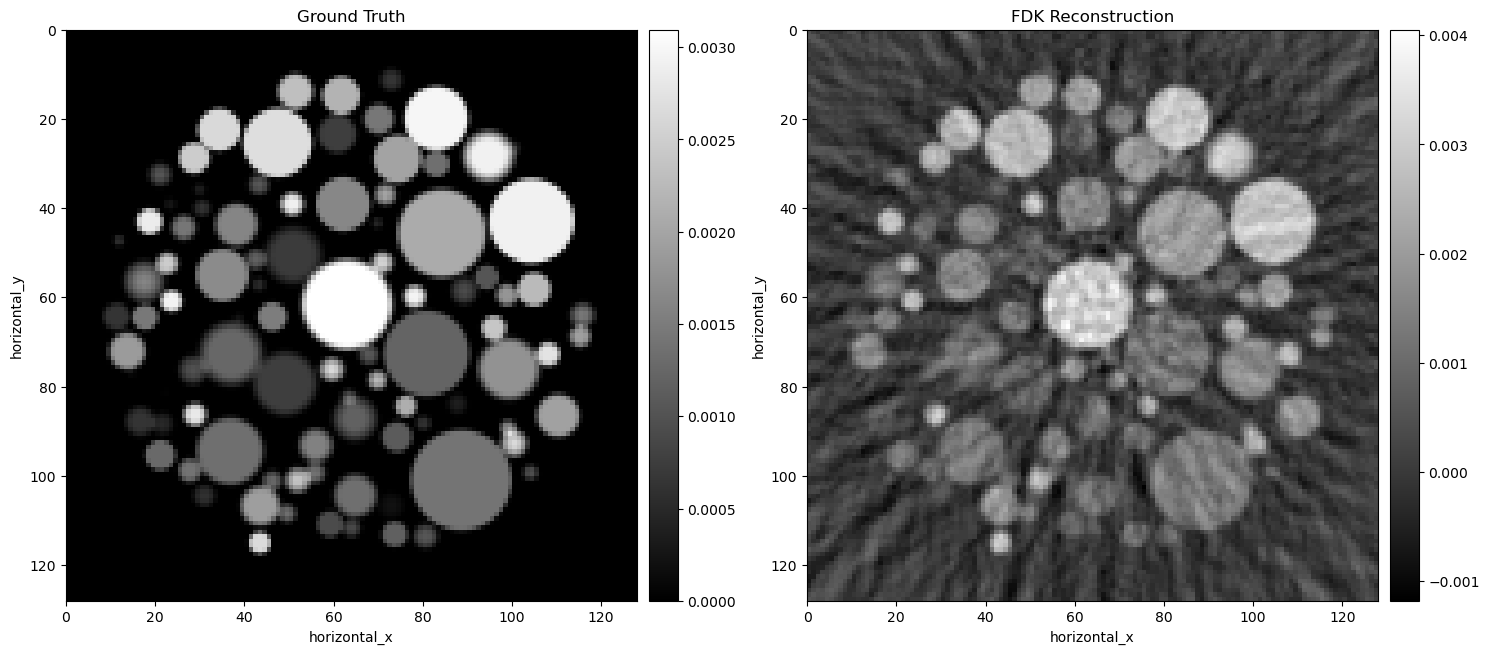

In [106]:

#%% Load data
ground_truth = dataexample.SIMULATED_SPHERE_VOLUME.get()

data = dataexample.SIMULATED_CONE_BEAM_DATA.get()
twoD = True
if twoD:
    data = data.get_slice(vertical='centre')
    ground_truth = ground_truth.get_slice(vertical='centre')

absorption = TransmissionAbsorptionConverter()(data)
absorption = Slicer(roi={'angle':(0, -1, 5)})(absorption)

ig = ground_truth.geometry

recon = FDK(absorption, image_geometry=ig).run()

show2D([ground_truth, recon], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2)




## Define point spread function 

In [107]:
def psf(n=5, sig=1.):
    """
    creates psf with side length `n` and a sigma of `sig`
    """
    ax = np.linspace(-(n - 1) / 2., (n - 1) / 2., n)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)
PSF=psf(5,2)
G=BlurringOperator(PSF,ig )

## Blur the image and recalculate the measured data, adding noise 

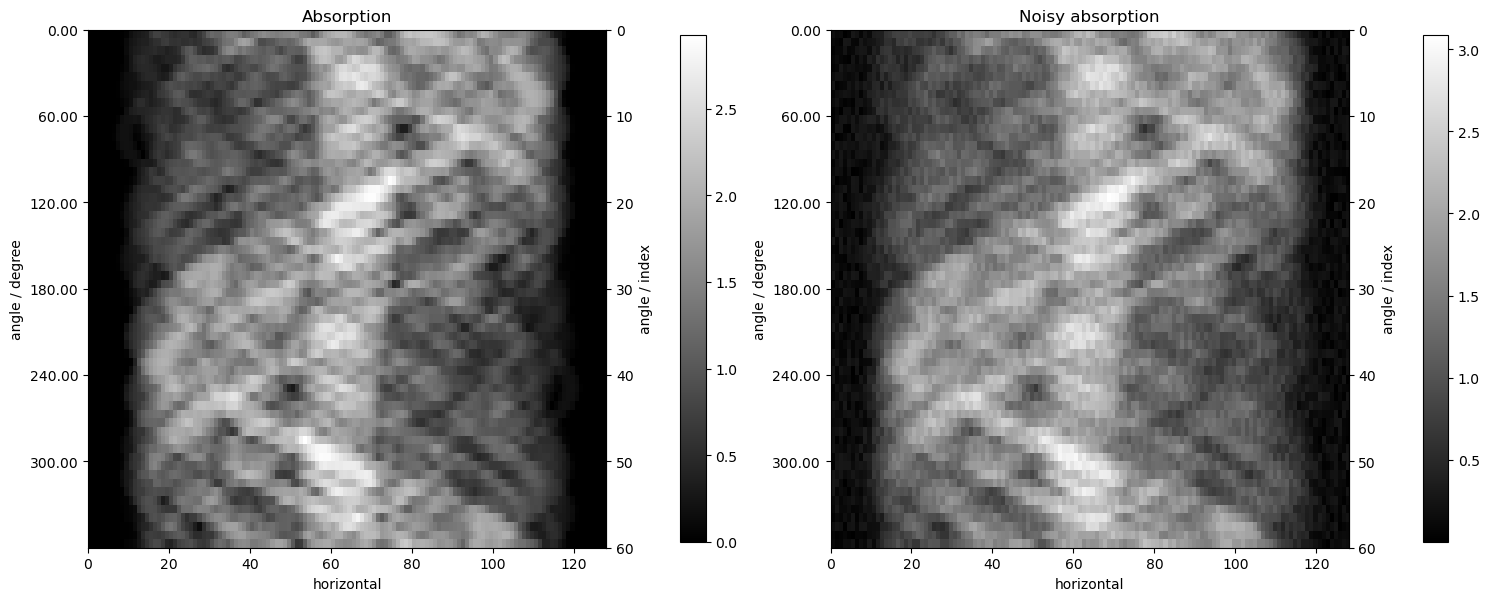

In [108]:

A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)


forward=CompositionOperator(A, G)
noisy_absorption=forward.direct(ground_truth) 
noisy_absorption+= 0.1*noisy_absorption.array.max()*noisy_absorption.geometry.allocate('random')

show2D([absorption, noisy_absorption], title = ['Absorption', 'Noisy absorption'], origin = 'upper', num_cols = 2)




## FDK reconstruction
We use the tomography forward model (ignoring the blurring operator) to produce an FDK reconstruction which is both blurred and noisy compared to the ground truth image. 


FDK recon

Input Data:
	angle: 60
	horizontal: 128

Reconstruction Volume:
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



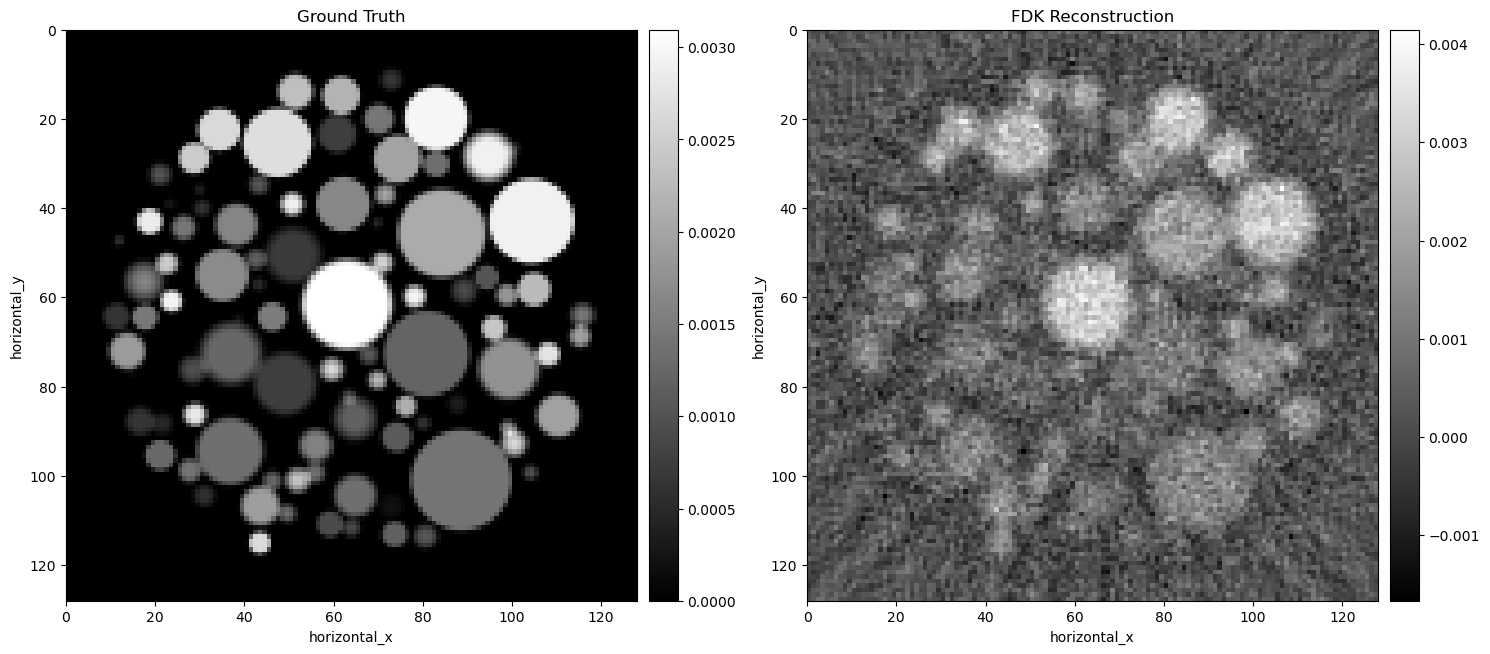

In [109]:
#%%

recon_FDK = FDK(noisy_absorption, image_geometry=ig).run()

show2D([ground_truth, recon_FDK], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2)


# %%

## FISTA + TV Recon 

As a baseline we try a TV reconstruction with a non-negativity constraint, using the FISTA algorithm, minimising the objective 

$$ \arg \min_x \|AGx-y\|_2^2  + \alpha g(x)$$ 

 where $G$ is the blurring operator, $A$ the tomographic projection, $ y$ the noisy measured data and $g$ is the TV regulariser with regularisation paramater $\alpha$. 

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.61496e+04
       50       1000         0.038          5.91448e+01
      100       1000         0.041          5.82746e+01
      150       1000         0.040          5.81926e+01
      200       1000         0.039          5.81801e+01
      250       1000         0.039          5.81773e+01
      300       1000         0.039          5.81761e+01
      350       1000         0.038          5.81757e+01
      400       1000         0.039          5.81754e+01
      450       1000         0.039          5.81754e+01
      500       1000         0.039          5.81752e+01
-------------------------------------------------------
      500       1000         0.039          5.81752e+01
Stop criterion has been reached.



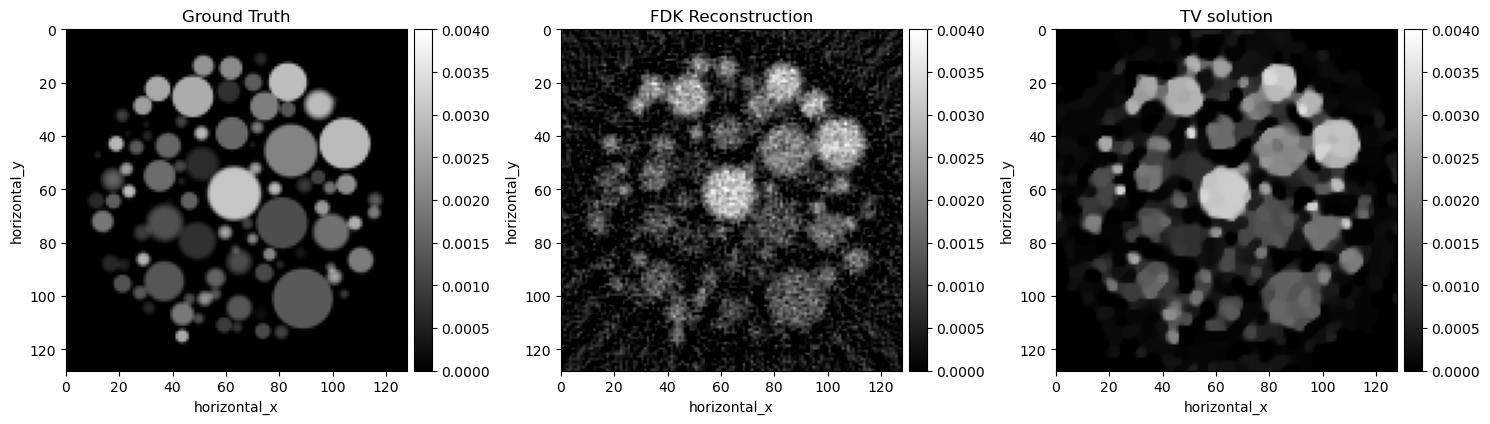

In [110]:


alpha=70.0

F = LeastSquares(A = forward, b = noisy_absorption)
G = alpha*TotalVariation(lower=0)

algo_tv=FISTA(initial=ig.allocate(0), f=F, g=G, max_iteration=1000, update_objective_interval=50)
algo_tv.run(500)
show2D([ground_truth, recon_FDK, algo_tv.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3, fix_range=(0,0.004))


# Directional Total Variation 

We use the directional total variation regulariser

$$g(x) =dTV:= \sum_i|D_i\nabla x_i|_2$$

 where the sum is over the pixels $i$ and where $D$ is a weighting vector filed on the gradient in $x$ dependent on the normalised gradient, $\zeta$,  of the reference image, $\nu$ so 
$$D=I-\zeta \zeta^T$$
and $$\zeta = -\dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}}$$ where $0<\eta<<\|\nabla\nu\|$.


We can see that if $\nabla x= \gamma \nabla \nu$ then

 $$D\nabla x = \gamma D\nabla \nu= \gamma (I-\zeta \zeta^T)\nabla \nu= \gamma \left(\nabla \nu -\dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}} \dfrac{\nabla \nu^T }{\sqrt{\eta^2+|\nabla\nu|^2}} \nabla \nu \right)=\gamma\nabla \nu \left(1-(1+\mathcal{O}(\frac{\eta^2}{\|\nabla\nu\|^2}) )\right) \approx 0.$$

We can also see if the gradient of the reconstructed image and the reference image are perpendicular, $\nabla x^T\nabla \nu=0$, then

$$D\nabla x (I-\zeta \zeta^T)\nabla x= \nabla \nu - \dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}} \dfrac{\nabla \nu^T }{\sqrt{\eta^2+|\nabla\nu|^2}} \nabla x =\nabla \nu $$

 and is non-zero. 

This regulariser encourages the gradient of the reconstructed image to be equal to parallel to the gradient of the reference image. 

The CCPi regularisation toolkit implementation also allows us to add a non-negativity constraint. 



## Create reference image 

Includes some but not all of the spheres and at different brightness to the ground truth image. 

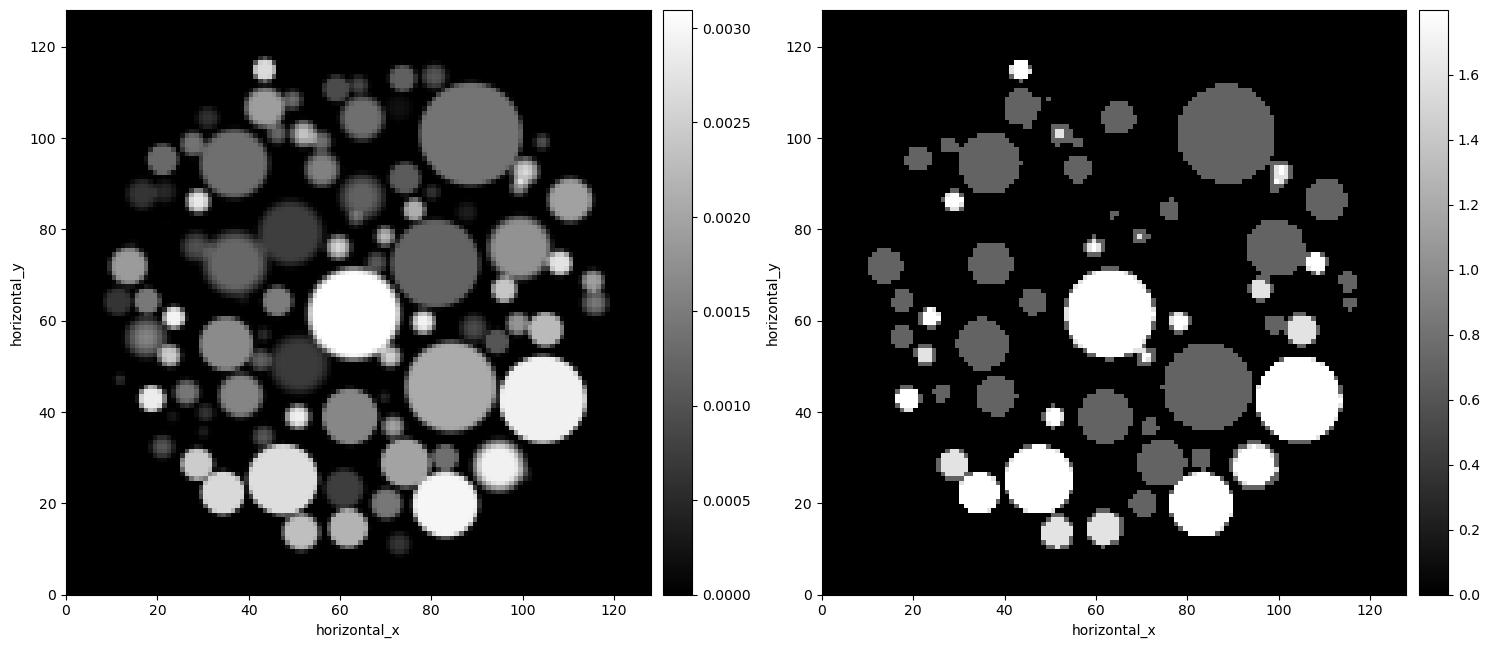

In [111]:
#%% create masks
top = ig.allocate(0)
bottom = ig.allocate(0)
middle= ig.allocate(0)

top.fill(
    np.asarray(ground_truth.array > 0.8 * ground_truth.max(), 
               dtype=np.float32)
    )
bottom.fill(
    np.asarray(np.invert(ground_truth.array < 0.4 * ground_truth.max()), 
               dtype=np.float32)
)
middle.fill(
    np.asarray(np.invert(  ground_truth.array< 0.7 * ground_truth.max()), 
               dtype=np.float32)
)


reference=top*0.2+bottom*0.7+ middle*0.9
show2D([ground_truth, reference])

## Directional TV regularisation, using the regularisation toolkit  


Setting a large alpha leads to a reproduction of the reference image but with the intensity values taken from the measured data: 

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000                     


/home/bih17925/miniconda3/envs/cil_23_1_0/lib/python3.10/site-packages/cil/plugins/ccpi_regularisation/functions/regularisers.py:403: UserWarning: FGP_dTV: the __call__ method is not implemented. Returning NaN.
  warnings.warn("{}: the __call__ method is not implemented. Returning NaN.".format(self.__class__.__name__))


       25       1000         0.020                     
       50       1000         0.020                     
       75       1000         0.019                     
      100       1000         0.019                     
      125       1000         0.018                     
      150       1000         0.018                     
      175       1000         0.018                     
      200       1000         0.018                     
-------------------------------------------------------
      200       1000         0.018                     
Stop criterion has been reached.



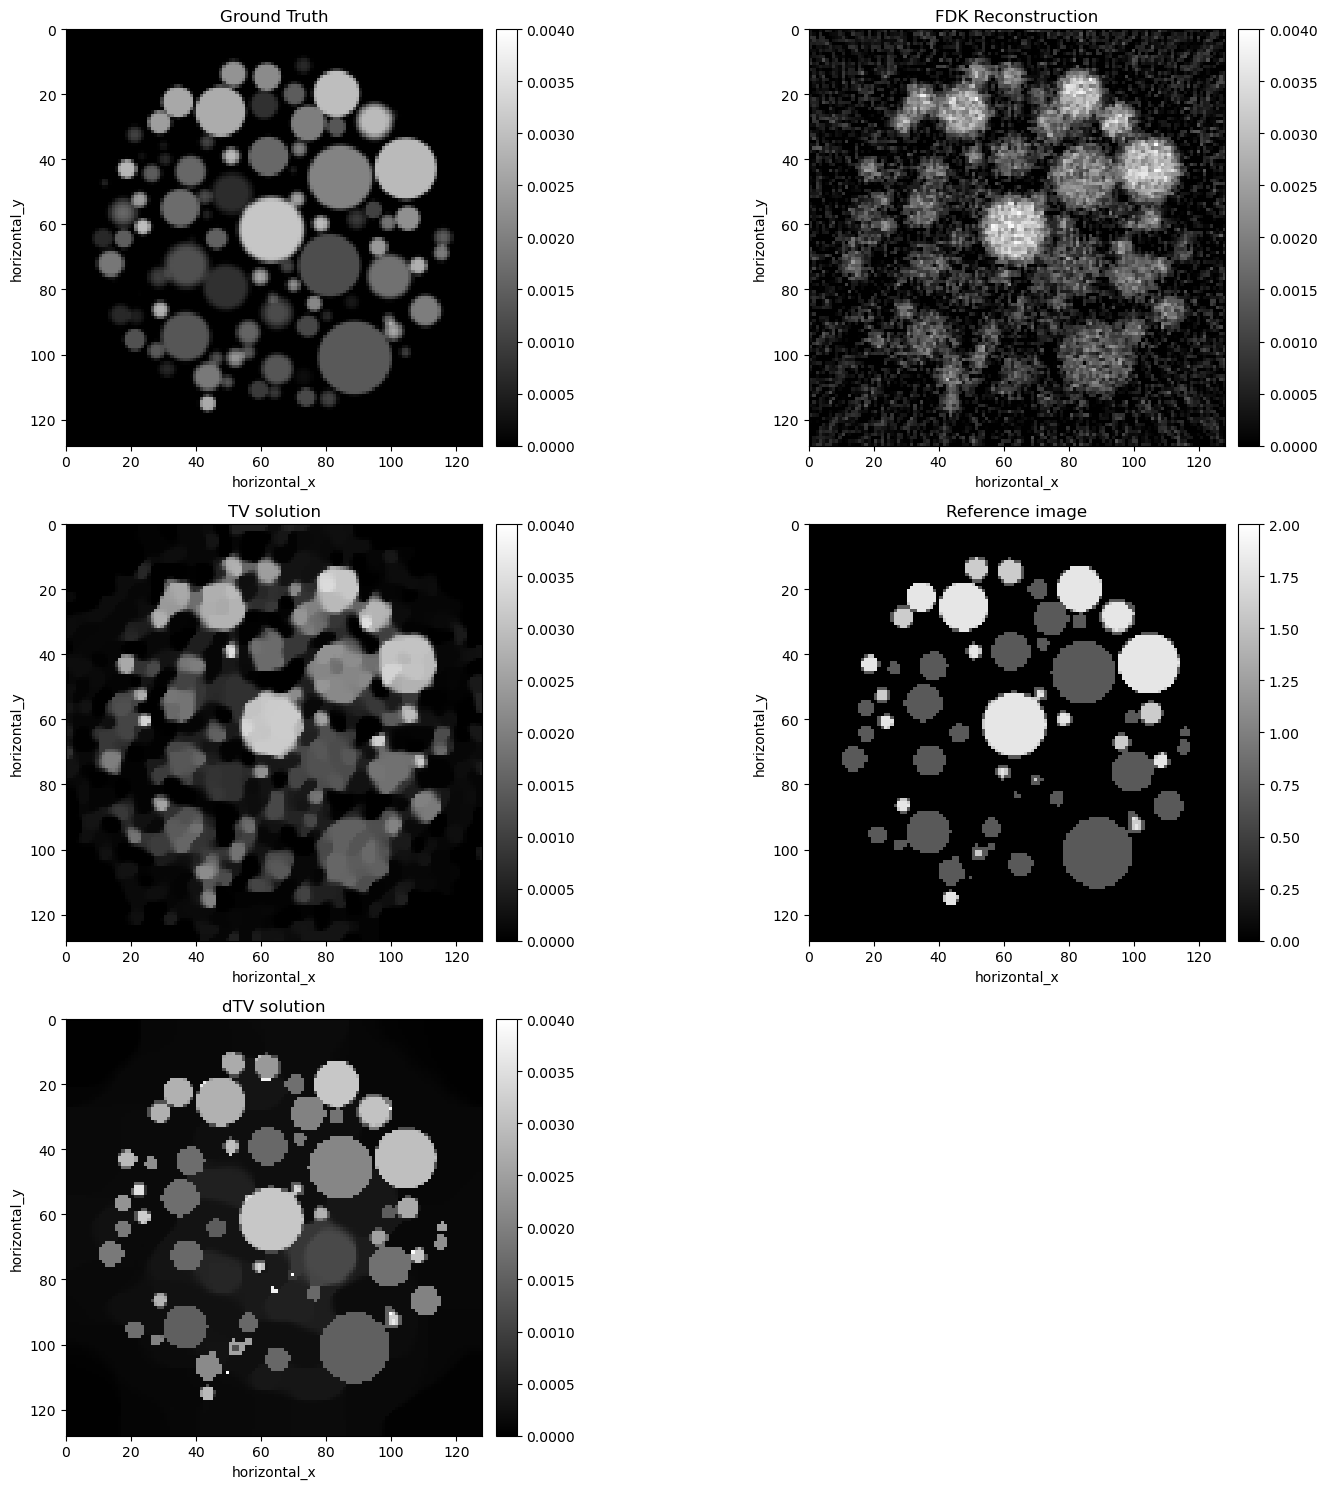

In [112]:

eta = 0.01
alpha = 100

F = LeastSquares(A = forward, b = noisy_absorption)
G=FGP_dTV(reference=reference, alpha=alpha, eta=eta, nonnegativity=True)

algo_dtv=FISTA(initial=ig.allocate(0), f=F, g=G, max_iteration=1000, update_objective_interval=25)
algo_dtv.run(200)
show2D([ground_truth, recon_FDK, algo_tv.solution, reference,  algo_dtv.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution', 'Reference image',  'dTV solution'], origin = 'upper', num_cols = 2, fix_range=[(0,0.004),(0,0.004),(0,0.004),(0,2),(0,0.004)])




We can see from the error images that there are spheres missing on the dTV reconstructed image. 

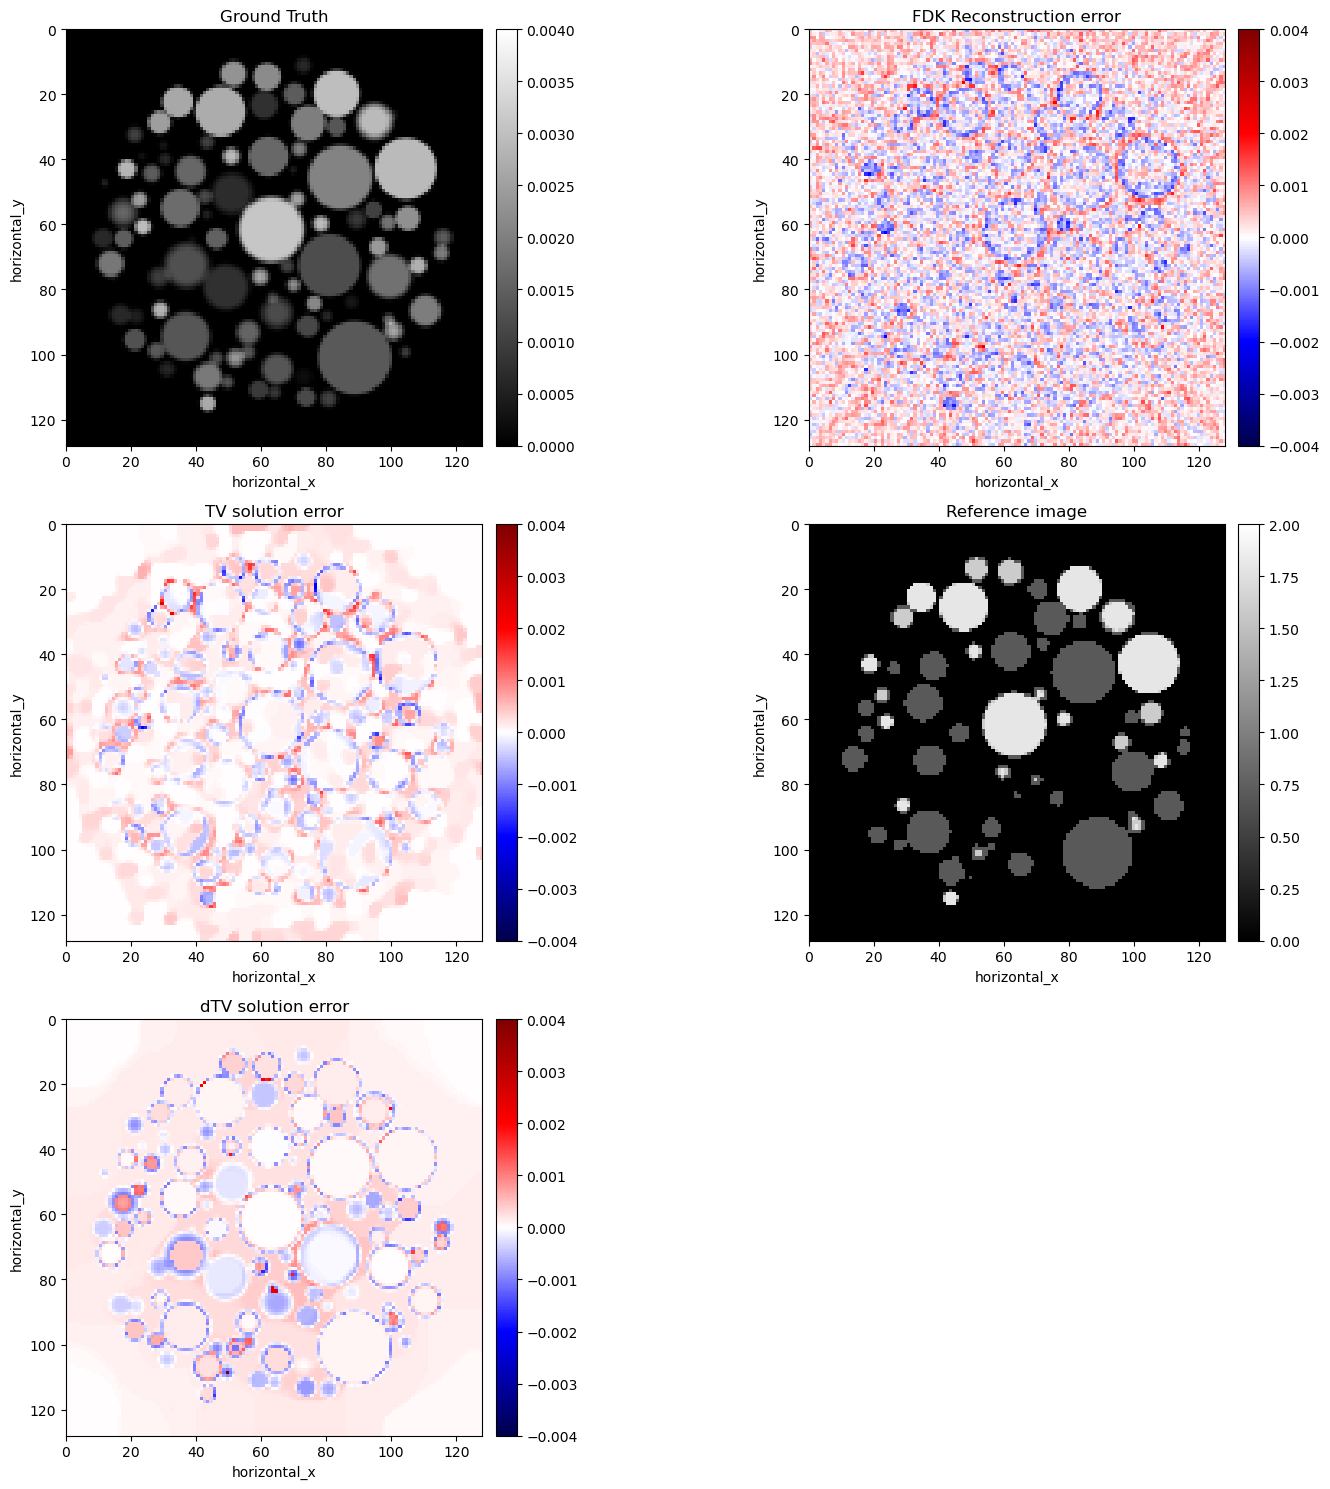

In [113]:
show2D([ground_truth, recon_FDK-ground_truth, algo_tv.solution-ground_truth, reference,  algo_dtv.solution-ground_truth], title = ['Ground Truth', 'FDK Reconstruction error', 'TV solution error', 'Reference image',  'dTV solution error'], origin = 'upper', cmap=['gray', 'seismic', 'seismic', 'gray', 'seismic'], num_cols = 2, fix_range=[(0, 0.004),(-0.004, 0.004),(-0.004, 0.004),(0,2),(-0.004, 0.004)])


For a value of alpha that is too small we see evidence that the inverse problem is ill posed the noise has been amplified by the reconstruction

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000                     
       25       1000         0.019                     
       50       1000         0.019                     
       75       1000         0.019                     
      100       1000         0.019                     


      125       1000         0.020                     
      150       1000         0.020                     
      175       1000         0.020                     
      200       1000         0.020                     
-------------------------------------------------------
      200       1000         0.020                     
Stop criterion has been reached.



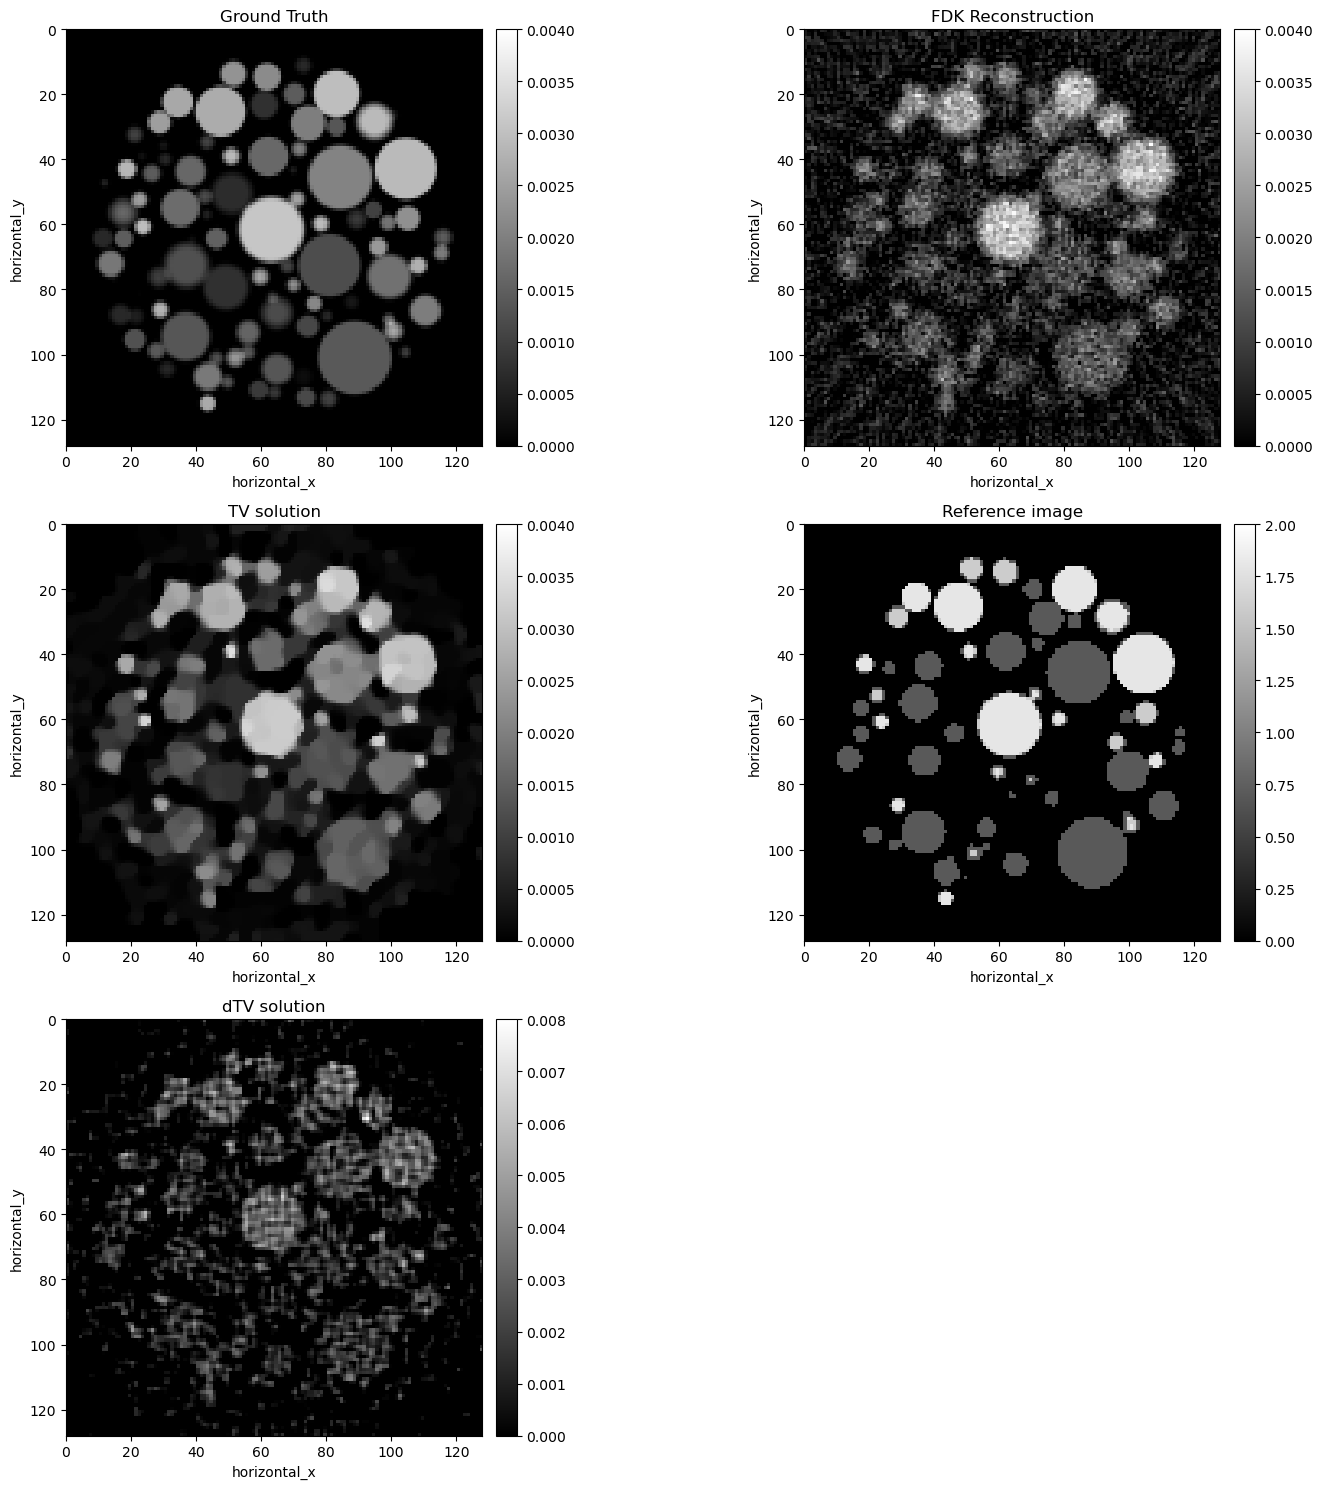

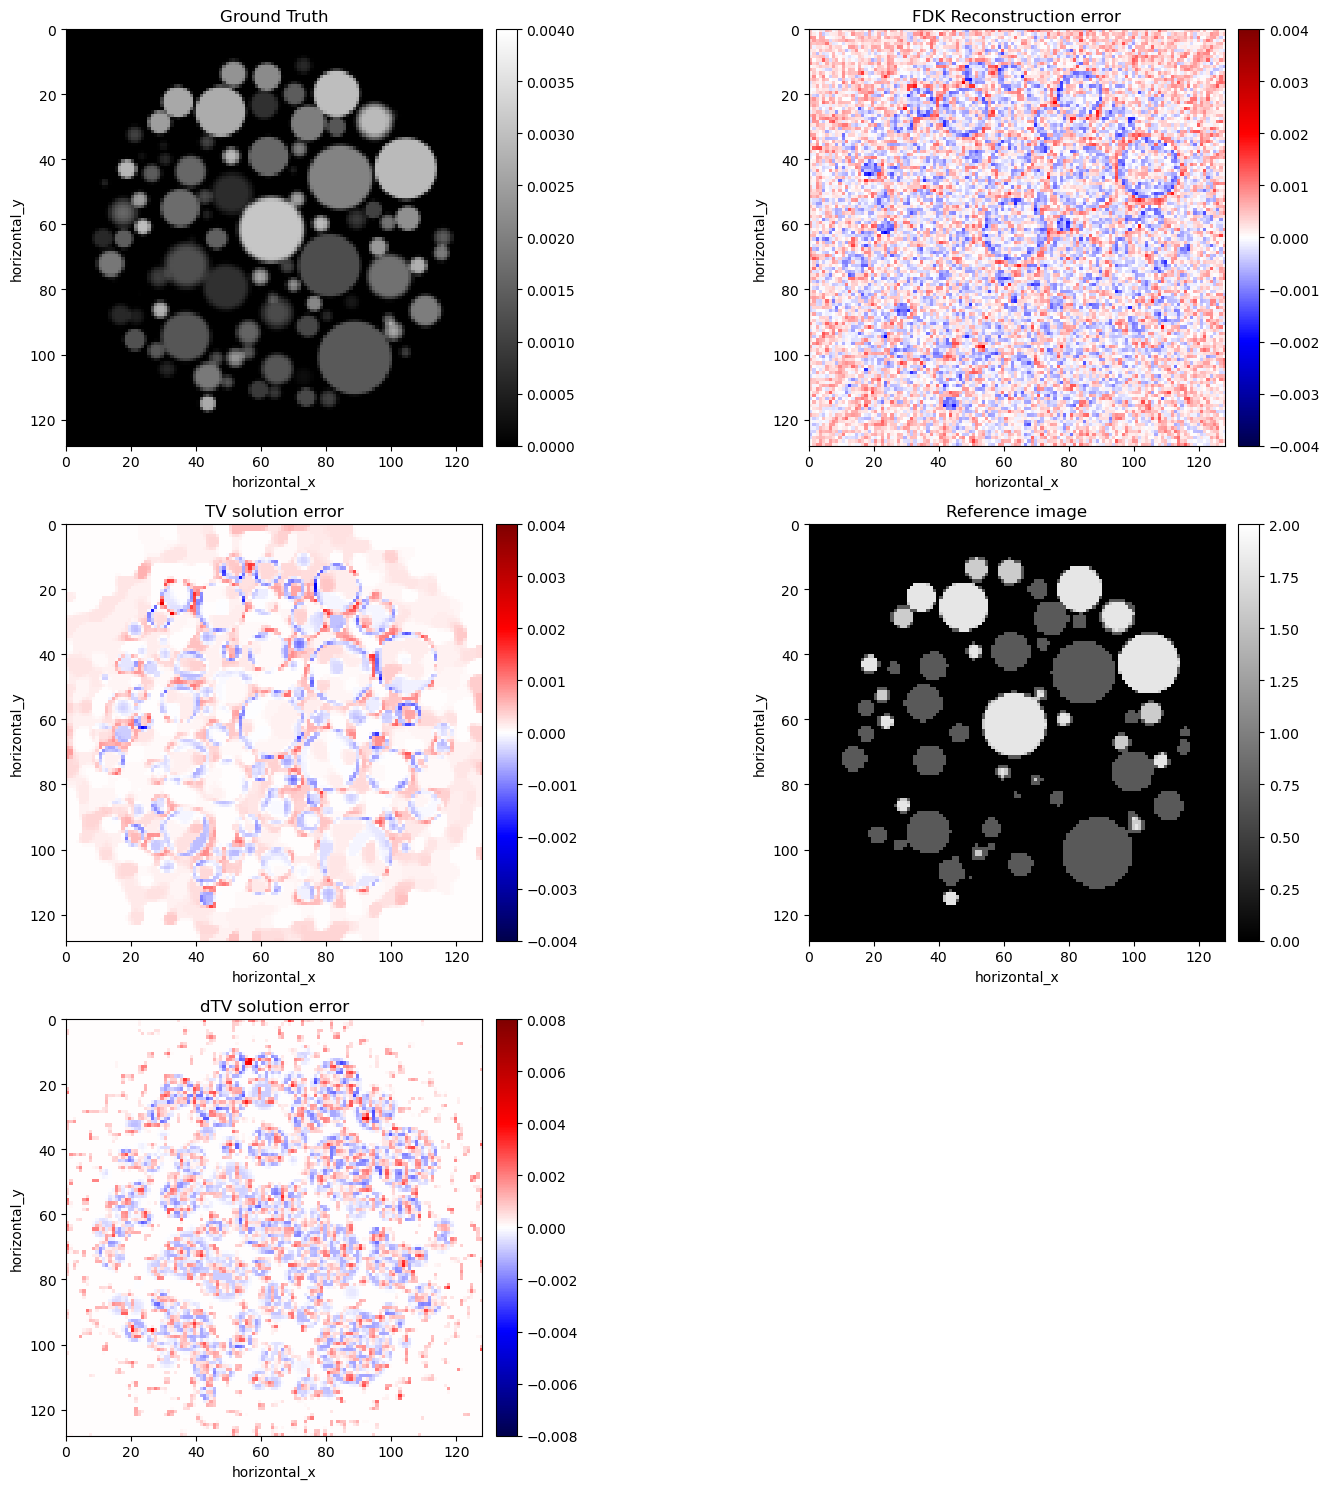

In [114]:

eta = 0.01
alpha = 0.001

F = LeastSquares(A = forward, b = noisy_absorption)
G=FGP_dTV(reference=reference, alpha=alpha, eta=eta, nonnegativity=True)

algo_dtv=FISTA(initial=ig.allocate(0), f=F, g=G, max_iteration=1000, update_objective_interval=25)
algo_dtv.run(200)
show2D([ground_truth, recon_FDK, algo_tv.solution, reference,  algo_dtv.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution', 'Reference image',  'dTV solution'], origin = 'upper', num_cols = 2, fix_range=[(0,0.004),(0,0.004),(0,0.004),(0,2),(0,0.008)])
show2D([ground_truth, recon_FDK-ground_truth, algo_tv.solution-ground_truth, reference,  algo_dtv.solution-ground_truth], title = ['Ground Truth', 'FDK Reconstruction error', 'TV solution error', 'Reference image',  'dTV solution error'], origin = 'upper', cmap=['gray', 'seismic', 'seismic', 'gray', 'seismic'], num_cols = 2, fix_range=[(0, 0.004),(-0.004, 0.004),(-0.004, 0.004),(0,2),(-0.008, 0.008)])




For intermediate values of alpha we are able to retain sharp edges but also find spheres not contained in the reference image: 

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000                     
       50       1000         0.018                     


      100       1000         0.018                     
      150       1000         0.018                     
      200       1000         0.018                     
-------------------------------------------------------
      200       1000         0.018                     
Stop criterion has been reached.



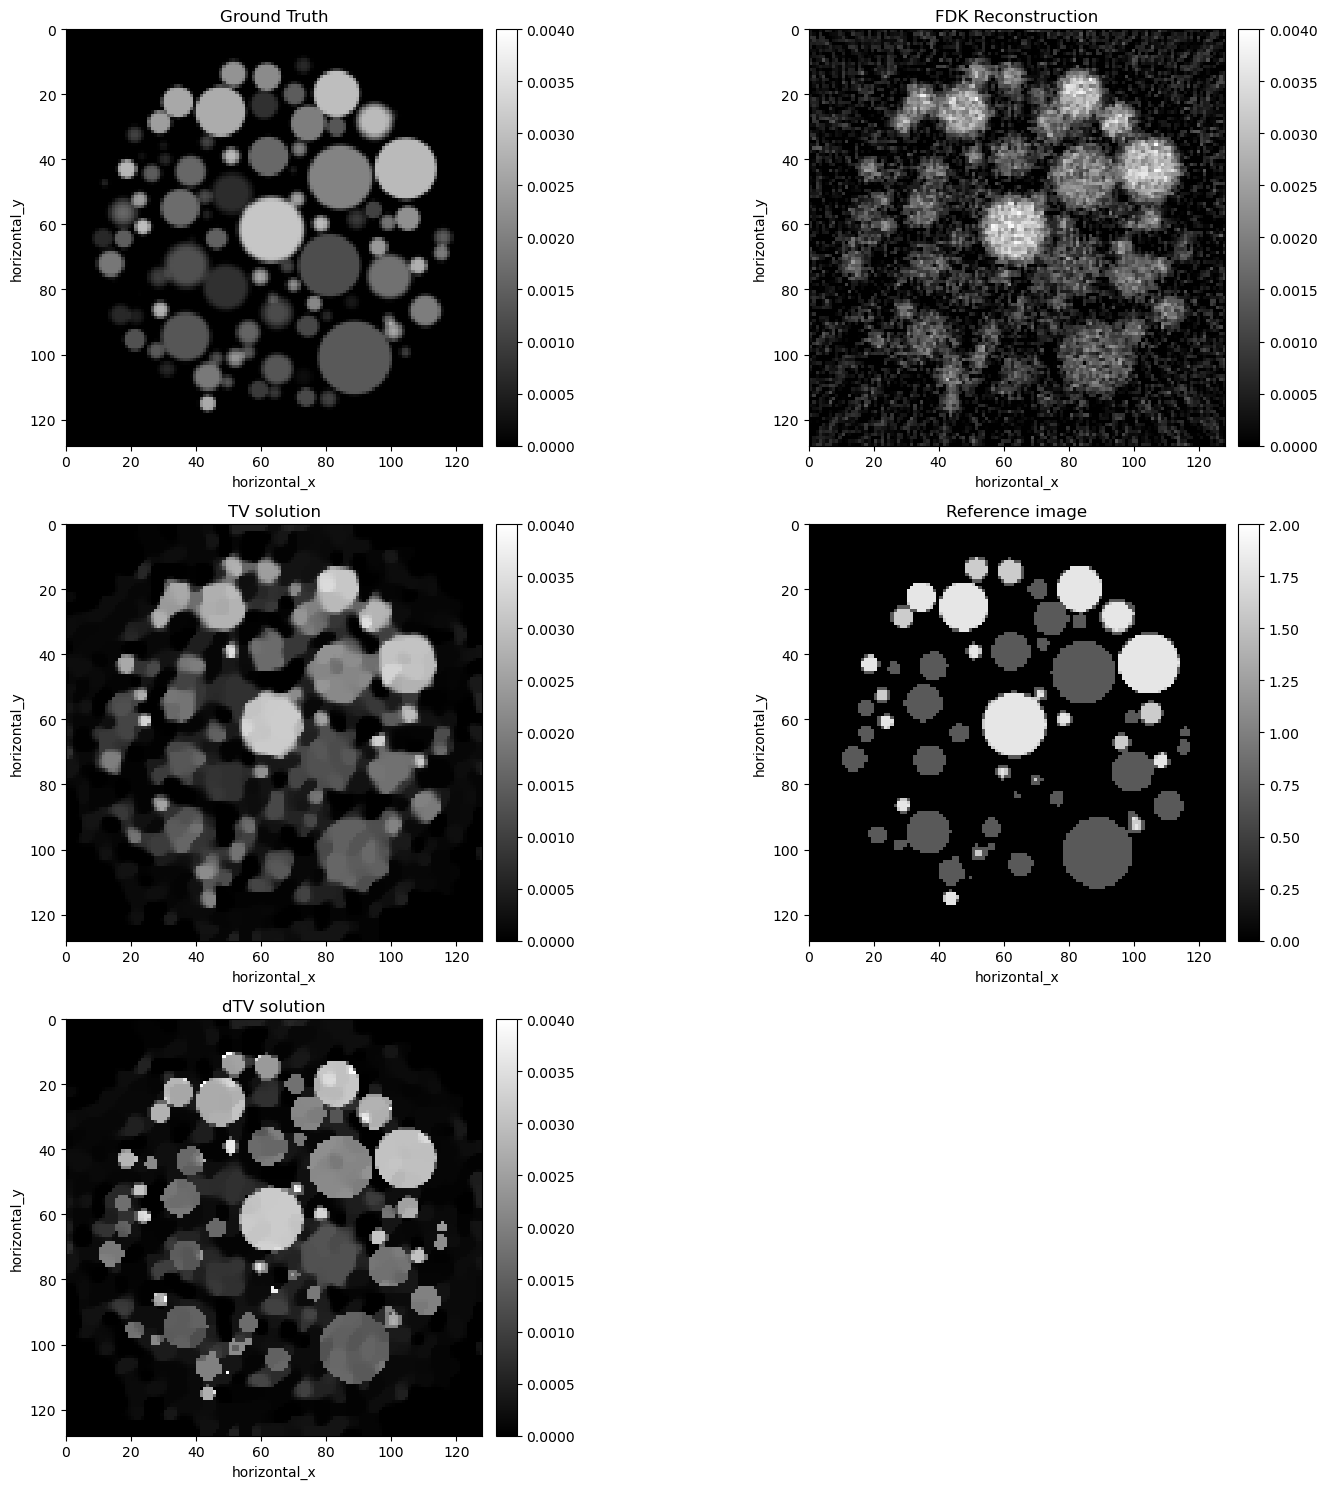

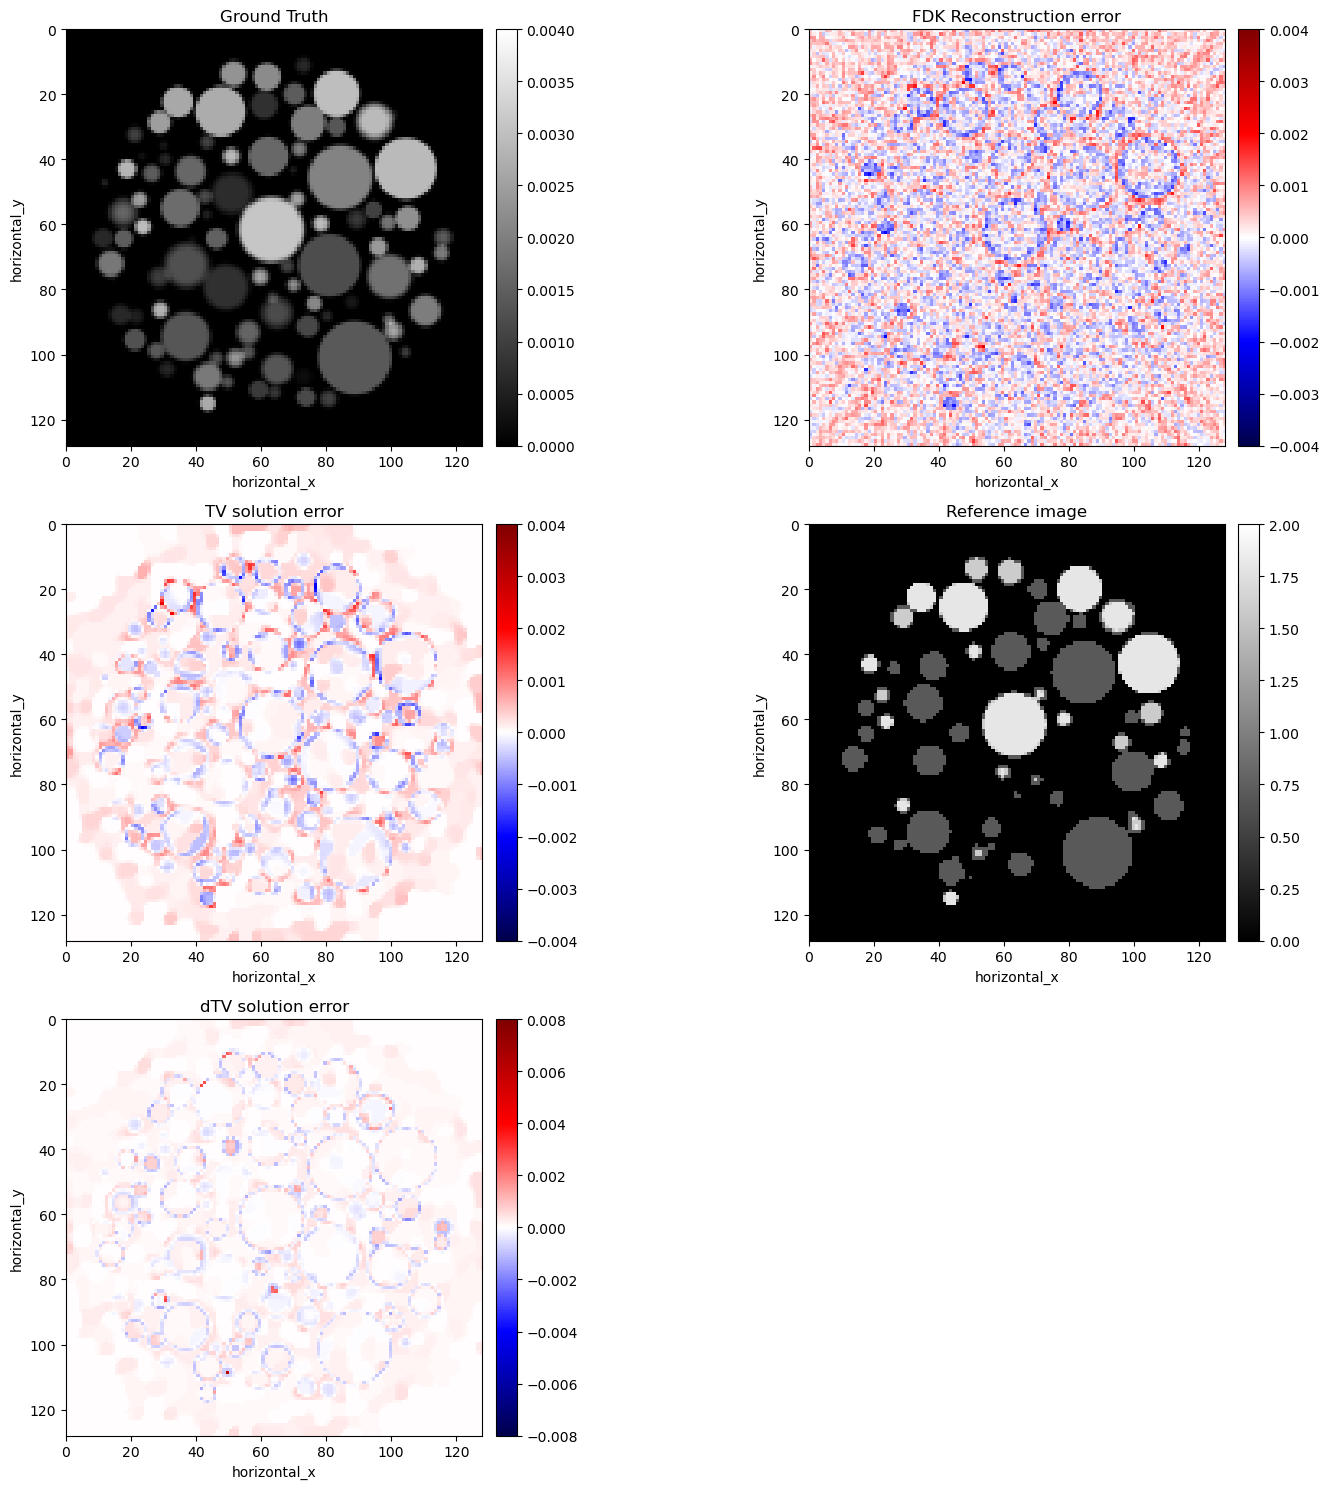

In [115]:

eta = 0.01
alpha = 5.0

F = LeastSquares(A = forward, b = noisy_absorption)
G=FGP_dTV(reference=reference, alpha=alpha, eta=eta, nonnegativity=True)

algo_dtv=FISTA(initial=ig.allocate(0), f=F, g=G, max_iteration=1000, update_objective_interval=50)
algo_dtv.run(200)
show2D([ground_truth, recon_FDK, algo_tv.solution, reference,  algo_dtv.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution', 'Reference image',  'dTV solution'], origin = 'upper', num_cols = 2, fix_range=[(0,0.004),(0,0.004),(0,0.004),(0,2),(0,0.004)])
show2D([ground_truth, recon_FDK-ground_truth, algo_tv.solution-ground_truth, reference,  algo_dtv.solution-ground_truth], title = ['Ground Truth', 'FDK Reconstruction error', 'TV solution error', 'Reference image',  'dTV solution error'], origin = 'upper', cmap=['gray', 'seismic', 'seismic', 'gray', 'seismic'], num_cols = 2, fix_range=[(0, 0.004),(-0.004, 0.004),(-0.004, 0.004),(0,2),(-0.008, 0.008)])



## Directional TV regularisation, written in CIL 

CIL currently can't take the proximal of an oeprator composition with a function so there is no proximal defined for the CIL LeastSquares function (https://github.com/TomographicImaging/CIL/issues/1561). We instead consider the CIL  L2NormSquared function where the proximal is defined and consider a denoising problem, denoising the FDK reconstruction using the directional TV regularisation term, i.e. solving the problem

$$ \arg \min_x \|x-x_{FDK}\|_2^2  + \alpha g(x) .$$ 

Note that this implementation was created by Vaggelis Papoutellis (https://github.com/TomographicImaging/CIL/pull/1121/files).


/home/bih17925/miniconda3/envs/cil_23_1_0/lib/python3.10/site-packages/cil/optimisation/algorithms/PDHG.py:348: UserWarning: Primal Acceleration of PDHG: The function g is assumed to be strongly convex with positive parameter `gamma_g`. You need to be sure that gamma_g = 1.0 is the correct strongly convex constant for g. 
  warnings.warn("Primal Acceleration of PDHG: The function g is assumed to be strongly convex with positive parameter `gamma_g`. You need to be sure that gamma_g = {} is the correct strongly convex constant for g. ".format(self.gamma_g))


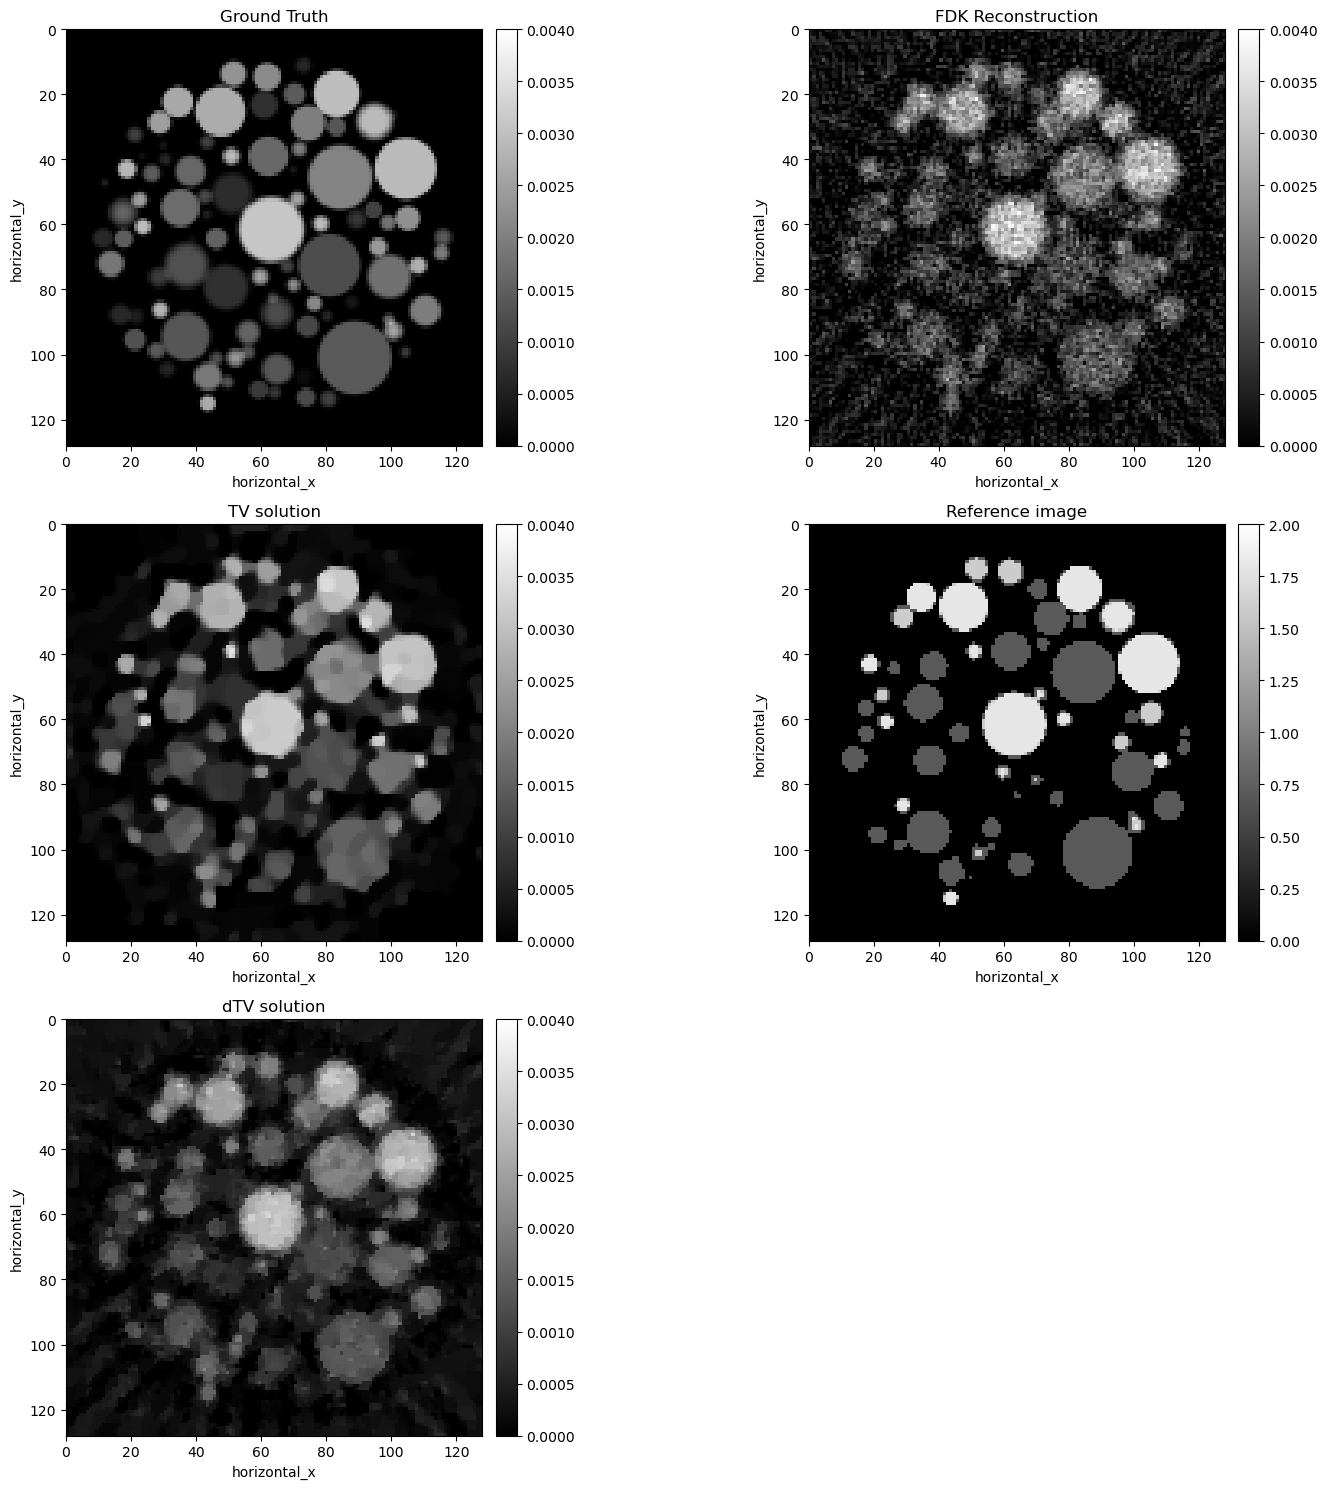

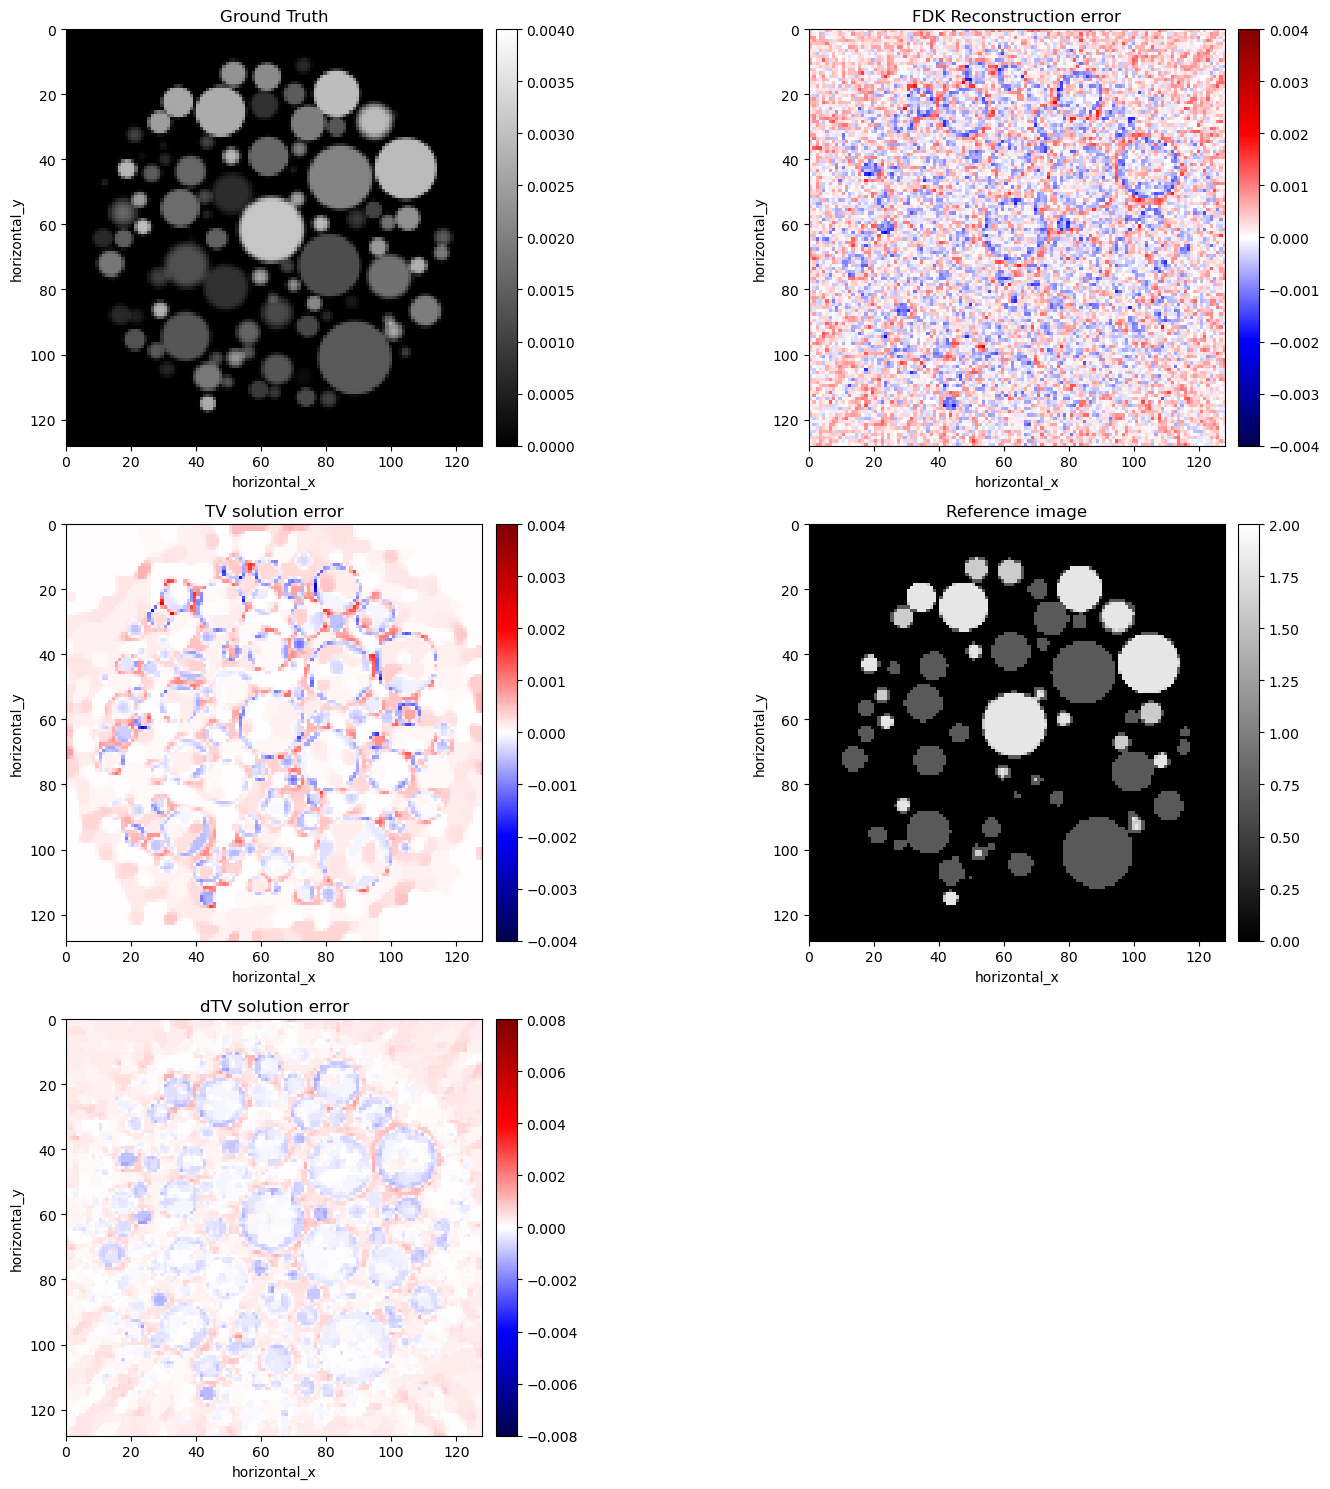

In [116]:
eta = 0.01
alpha = 0.008


# fidelity term
g = L2NormSquared( b=recon_FDK)

# setup operator for directional TV
DY = FiniteDifferenceOperator(ig, direction=1)
DX = FiniteDifferenceOperator(ig, direction=0)

Grad = BlockOperator(DY, DX)
grad_ref = Grad.direct(reference)
denom = (eta**2 + grad_ref.pnorm(2)**2).sqrt()
xi = grad_ref/denom

A1 = DY - CompositionOperator(DiagonalOperator(xi[0]**2),DY) - CompositionOperator(DiagonalOperator(xi[0]*xi[1]),DX)
A2 = DX - CompositionOperator(DiagonalOperator(xi[0]*xi[1]),DY) - CompositionOperator(DiagonalOperator(xi[1]**2),DX)

operator = BlockOperator(A1, A2)

f = alpha * MixedL21Norm()

# use primal acceleration, g being strongly convex
pdhg = PDHG(f = f, g = g, operator = operator, 
            max_iteration=500, update_objective_interval = 100, gamma_g = 1.)
pdhg.run(verbose=0)        


show2D([ground_truth, recon_FDK, algo_tv.solution, reference,  pdhg.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution', 'Reference image',  'dTV solution'], origin = 'upper', num_cols = 2, fix_range=[(0,0.004),(0,0.004),(0,0.004),(0,2),(0,0.004)])
show2D([ground_truth, recon_FDK-ground_truth, algo_tv.solution-ground_truth, reference,  pdhg.solution-ground_truth], title = ['Ground Truth', 'FDK Reconstruction error', 'TV solution error', 'Reference image',  'dTV solution error'], origin = 'upper', cmap=['gray', 'seismic', 'seismic', 'gray', 'seismic'], num_cols = 2, fix_range=[(0, 0.004),(-0.004, 0.004),(-0.004, 0.004),(0,2),(-0.008, 0.008)])


With less information, in the form of the forward model, the outcome is not as good, but arguably still better than the TV reconstruction. 

In [117]:
#TODO: Add some PSNR values or some other metric
#TODO: try a wider range of regularisation parameters 
# TODO:  TRY some downsampling 